X variables:
    Month  DayOfWeek  EvenCount  OddCount  HighCount  LowCount  \
0      5          3          3         3          1         5   
1      5          0          4         2          4         2   
2      5          3          4         2          4         2   
3      5          0          2         4          2         4   
4      5          3          0         6          4         2   

   Winning Number 1  Winning Number 2  Winning Number 3  Winning Number 4  \
0                 5                 8                13                20   
1                21                22                40                41   
2                15                20                36                38   
3                 5                12                15                21   
4                 7                13                35                39   

   Winning Number 5  Winning Number 6  
0                21                46  
1                42                46  
2           

/var/folders/26/1sqcgyf96cb0q8fj7pqq1c5m0000gn/T/ipykernel_39321/3886701519.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette="viridis")


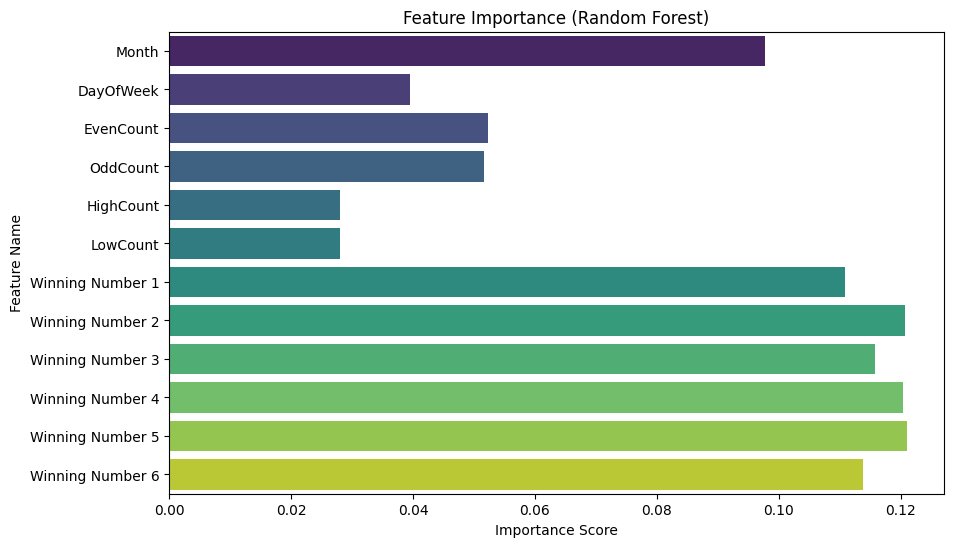

📌 **Feature Importance Interpretation:**
🔹 If 'Month' is most important, then some months may be more likely to have winners.
🔹 If 'DayOfWeek' is dominant, jackpot draws may favor certain days.



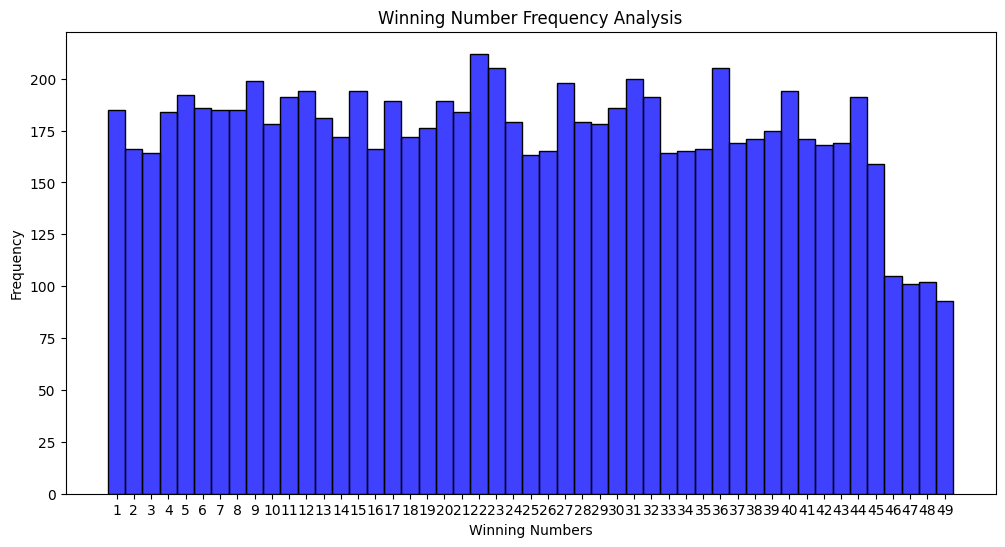

📌 **Winning Number Frequency Analysis:**
🔹 Taller bars indicate numbers that appear more frequently.
🔹 If all numbers have similar frequency, then draws are well-randomized.



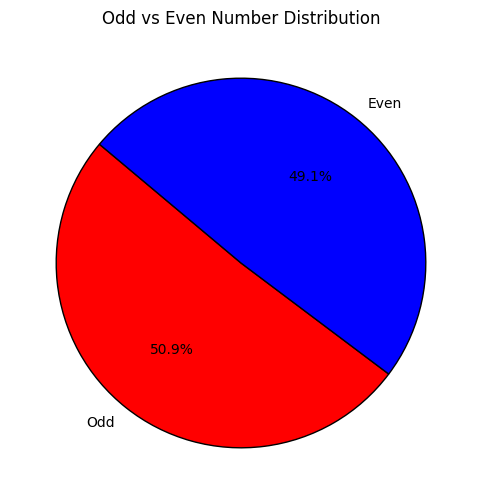

📌 **Odd vs Even Distribution:**
🔹 Odd numbers appeared 4351 times.
🔹 Even numbers appeared 4205 times.
🔹 If odd/even numbers are balanced (~50%), then the draw is likely unbiased.
🔹 If one dominates (>60%), it may indicate a trend.



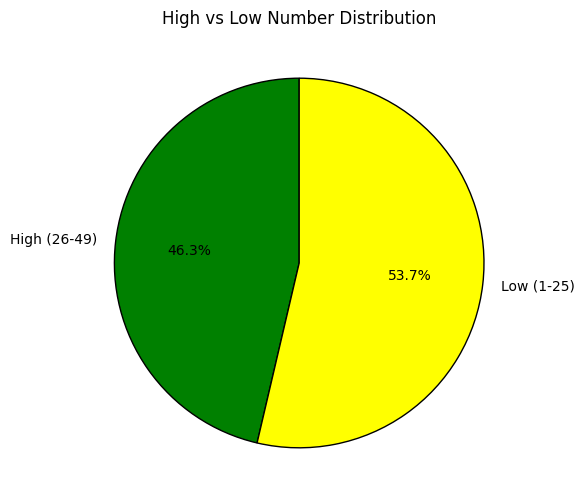

📌 **High vs Low Number Analysis:**
🔹 High numbers (26-49) appeared 3965 times.
🔹 Low numbers (1-25) appeared 4591 times.
🔹 If high and low numbers are balanced (~50%), then the draw is likely random.
🔹 If one category dominates (>60%), it suggests a potential trend in high/low number selection.



NameError: name 'features' is not defined

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# ============================
# 🔹 1️⃣ LOAD & PREPROCESS DATA 🔹
# ============================

# ✅ Step 1: Load Dataset
df = pd.read_csv('Toto Winning Numbers.csv')

# ✅ Step 2: Preprocess Data
df.columns = df.columns.str.strip()  # Clean column names
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Extract Winning Number columns
winning_cols = [col for col in df.columns if 'Winning Number' in col]

# ✅ Step 3: Feature Engineering
df['EvenCount'] = df[winning_cols].apply(lambda x: sum(num % 2 == 0 for num in x), axis=1)
df['OddCount'] = df[winning_cols].apply(lambda x: sum(num % 2 != 0 for num in x), axis=1)
df['HighCount'] = df[winning_cols].apply(lambda x: sum(num > 25 for num in x), axis=1)
df['LowCount'] = df[winning_cols].apply(lambda x: sum(num <= 25 for num in x), axis=1)

# ✅ Step 4: Define Target Variable (Winning Group)
df['WinningGroup'] = (df['Division 1 Winners'] > 0).astype(int)

# ✅ Step 5: Select Features & Split Data
X = df[['Month', 'DayOfWeek', 'EvenCount', 'OddCount', 'HighCount', 'LowCount'] + winning_cols]
y = df['WinningGroup']

print("X variables:\n", X.head())
print("\ny variable:\n", y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===================================
# 🔹 5️⃣ MACHINE LEARNING MODELS 🔹
# ===================================

models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=15, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7)
}

for name, model in models.items():
    model.fit(X_train, y_train)  
    predictions = model.predict(X_test)  

    print(f"\n📊 {name} Performance for Winning Group Prediction:")
    print(classification_report(y_test, predictions))  
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # 🔎 Interpretation
    if name == "Random Forest":
        print("🔹 The Random Forest model generally performs well in handling complex patterns.\n"
              "🔹 If accuracy is high (>60%), this suggests that month/day trends have some predictive power.\n"
              "🔹 If accuracy is low (~50%), it means winning draws are more random and harder to predict.\n")
        
    elif name == "Decision Tree":
        print("🔹 Decision Trees help visualize how winning numbers correlate with the month/day.\n"
              "🔹 If accuracy is close to Random Forest, it suggests strong feature importance.\n"
              "🔹 If accuracy is lower than Random Forest, it means overfitting or weak patterns.\n")

    elif name == "KNN":
        print("🔹 KNN predicts based on historical proximity.\n"
              "🔹 If accuracy is poor (~50%), it suggests past results have little impact on future draws.\n")

# ====================================================
# 🔹 6️⃣ FEATURE IMPORTANCE (TREE-BASED MODELS) 🔹
# ====================================================

rf_model = models['Random Forest']
feature_importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance (Random Forest)")
plt.show()

print("📌 **Feature Importance Interpretation:**\n"
      "🔹 If 'Month' is most important, then some months may be more likely to have winners.\n"
      "🔹 If 'DayOfWeek' is dominant, jackpot draws may favor certain days.\n")

# ============================
# 🔹 7️⃣ WINNING NUMBER ANALYSIS 🔹
# ============================

plt.figure(figsize=(12, 6))
winning_numbers = df[[col for col in df.columns if 'Winning Number' in col]].values.flatten()
sns.histplot(winning_numbers, bins=np.arange(1, 51) - 0.5, kde=False, color="blue")
plt.xticks(np.arange(1, 50))
plt.xlabel("Winning Numbers")
plt.ylabel("Frequency")
plt.title("Winning Number Frequency Analysis")
plt.show()

print("📌 **Winning Number Frequency Analysis:**\n"
      "🔹 Taller bars indicate numbers that appear more frequently.\n"
      "🔹 If all numbers have similar frequency, then draws are well-randomized.\n")

# ============================
# 🔹 8️⃣ ODD/EVEN & HIGH/LOW ANALYSIS 🔹
# ============================

# ✅ Ensure winning numbers are properly extracted
winning_numbers = df[[col for col in df.columns if 'Winning Number' in col]].values.flatten()
winning_numbers = winning_numbers[~np.isnan(winning_numbers)]

# 📊 Odd vs Even Distribution
odd_even_counts = [np.sum(winning_numbers % 2 == 1), np.sum(winning_numbers % 2 == 0)]

plt.figure(figsize=(6, 6))
plt.pie(odd_even_counts, labels=['Odd', 'Even'], autopct='%1.1f%%', 
        colors=['red', 'blue'], startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Odd vs Even Number Distribution")
plt.show()

print("📌 **Odd vs Even Distribution:**\n"
      f"🔹 Odd numbers appeared {odd_even_counts[0]} times.\n"
      f"🔹 Even numbers appeared {odd_even_counts[1]} times.\n"
      "🔹 If odd/even numbers are balanced (~50%), then the draw is likely unbiased.\n"
      "🔹 If one dominates (>60%), it may indicate a trend.\n")

# 📊 High vs Low Number Distribution (Using actual counts)
high_low_counts = [np.sum(winning_numbers > 25), np.sum(winning_numbers <= 25)]

plt.figure(figsize=(6, 6))
plt.pie(high_low_counts, labels=['High (26-49)', 'Low (1-25)'], autopct='%1.1f%%', 
        colors=['green', 'yellow'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("High vs Low Number Distribution")
plt.show()

print("📌 **High vs Low Number Analysis:**\n"
      f"🔹 High numbers (26-49) appeared {high_low_counts[0]} times.\n"
      f"🔹 Low numbers (1-25) appeared {high_low_counts[1]} times.\n"
      "🔹 If high and low numbers are balanced (~50%), then the draw is likely random.\n"
      "🔹 If one category dominates (>60%), it suggests a potential trend in high/low number selection.\n")

# ============================
# 🔹 9️⃣ NUMBER RECOMMENDATION 🔹
# ============================

def suggest_numbers(features, n=6):
    hot_numbers = features.sort_values(by='Hot', ascending=False).head(n//2)['Number'].tolist()
    cold_numbers = features.sort_values(by='Cold', ascending=False).head(n//2)['Number'].tolist()
    recommended_numbers = list(set(hot_numbers + cold_numbers))[:n]  

    return {"Hot": hot_numbers, "Cold": cold_numbers, "Balanced Selection": recommended_numbers}

number_suggestions = suggest_numbers(features)

hot_cold_df = features.sort_values(by='Hot', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Number', y='Hot', data=hot_cold_df, color='red', label='Hot Numbers')
sns.barplot(x='Number', y='Cold', data=hot_cold_df, color='blue', label='Cold Numbers')
plt.title("Top 10 Hot vs Cold Numbers")
plt.legend()
plt.show()

print(f"\n🔥 **Hot Picks (Most Frequent Numbers):** {number_suggestions['Hot']}")
print(f"❄️ **Cold Picks (Least Drawn Numbers):** {number_suggestions['Cold']}")
print(f"🎯 **Balanced Selection:** {number_suggestions['Balanced Selection']}")

print("📌 **Number Recommendation Interpretation:**\n"
      "🔹 Hot numbers are historically frequent, but past results don't guarantee future wins.\n"
      "🔹 Cold numbers are rarely drawn, but may be overdue for selection.\n")
